
# ЛР 2. Очистка и восполнение данных. Скользящее среднее. Интерполяция. Экспоненциальное сглаживание

Баранов Владимир, ШАД-311

**Исходные данные:** `passengers2.csv` (поля: `Month`, `reference`, `target`, `missing`)

В ходе лабораторной работы были реализованы следующие этапы:

1. **Заполнение пропусков предыдущими наблюдениями** — метод основан на сдвиге значений с помощью `shift()` и альтернативно выполнен через `ffill()` для проверки эквивалентности результатов.  

2. **Метод скользящего среднего** с окном `window = 3`:
   - ручная реализация как среднее трёх предыдущих точек;
   - применение встроенного метода `rolling(...).mean()`.

3. **Линейная интерполяция пропусков**:
   - вручную, по формуле через соседние (левую и правую) точки;
   - встроенным методом `interpolate()` из pandas.

4. Для каждого из перечисленных подходов построены **графики сравнения восстановленного ряда `target` и эталонного `reference`**.  

5. Проведено **простое экспоненциальное сглаживание** временного ряда `reference`:
   - расчёт по аналитической формуле;
   - реализация через метод `ewm(...).mean()`.

Все визуализации выполнены относительно общей временной шкалы `Month` в формате datetime.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", 50)
pd.set_option("display.width", 120)

np.random.seed(42)



## 1. Загрузка и первичный осмотр данных

In [2]:
df = pd.read_csv('/content/passengers2.csv')

df['Month'] = pd.to_datetime(df['Month'])
df = df.sort_values('Month').reset_index(drop=True)

print(df.head(10))
print(df.info())

       Month  reference  target  missing
0 1949-01-01        112   112.0      NaN
1 1949-02-01        118   118.0      NaN
2 1949-03-01        132   132.0      NaN
3 1949-04-01        129     NaN    129.0
4 1949-05-01        121   121.0      NaN
5 1949-06-01        135   135.0      NaN
6 1949-07-01        148   148.0      NaN
7 1949-08-01        148     NaN    148.0
8 1949-09-01        136   136.0      NaN
9 1949-10-01        119     NaN    119.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Month      144 non-null    datetime64[ns]
 1   reference  144 non-null    int64         
 2   target     116 non-null    float64       
 3   missing    28 non-null     float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 4.6 KB
None



### Визуализация исходных данных (`reference` vs `target` с пропусками)


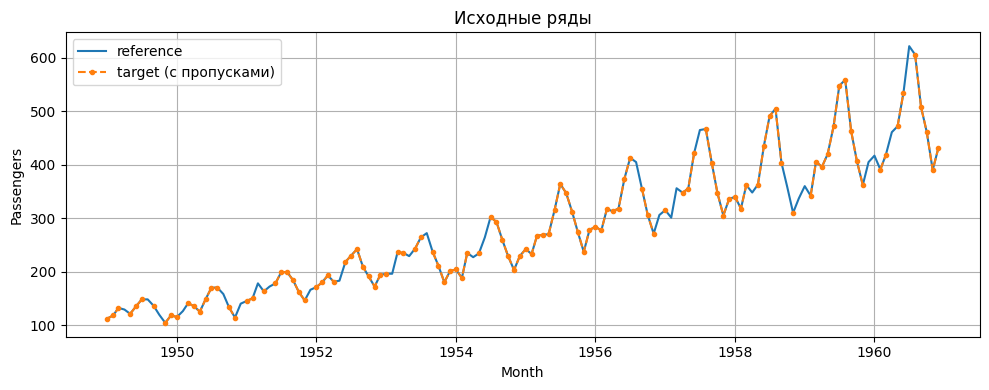

In [3]:
plt.figure(figsize=(10,4))
plt.plot(df['Month'], df['reference'], label='reference')
plt.plot(df['Month'], df['target'], label='target (с пропусками)', linestyle='--', marker='o', markersize=3)
plt.title('Исходные ряды')
plt.xlabel('Month')
plt.ylabel('Passengers')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



## 2. Восполнение предыдущими значениями через `shift`

Для каждой пропущенной точки `target[t]` подставить **значение на предыдущем шаге** `target[t-1]`.

- В pandas это удобно сделать через смещение `shift(1)`, чтобы предыдущие значения стали выровнены под текущими индексами.
- Далее `fillna` вставит эти смещённые значения только в позиции пропусков.

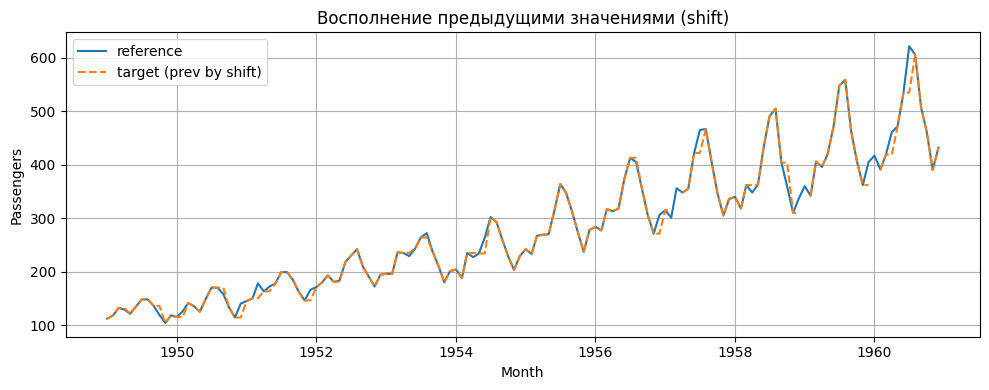

In [4]:
target = df['target'].copy()

prev_values = target.shift(1)
filled_prev = target.copy()
filled_prev = filled_prev.fillna(prev_values)

filled_ffill = target.ffill()

df['filled_prev_shift'] = filled_prev
df['filled_prev_ffill'] = filled_ffill

plt.figure(figsize=(10,4))
plt.plot(df['Month'], df['reference'], label='reference')
plt.plot(df['Month'], df['filled_prev_shift'], label='target (prev by shift)', linestyle='--')
plt.title('Восполнение предыдущими значениями (shift)')
plt.xlabel('Month'); plt.ylabel('Passengers'); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()



## 3. Восполнение скользящим средним (окно = 3)

Требуется два варианта:

1) График 1: **По формуле**: для пропуска в момент `t` подставляем среднее **трёх предыдущих доступных значений** (t-1, t-2, t-3).  
   Корректно учитывать пропуски и края — используем `shift(1).rolling(window=3, min_periods=1).mean()` как источник среднего предыдущих значений.

2) График 2: **Через `rolling().mean()`**: скользящее среднее окна 3 по самому `target`, затем использовать его для заполнения пропусков.


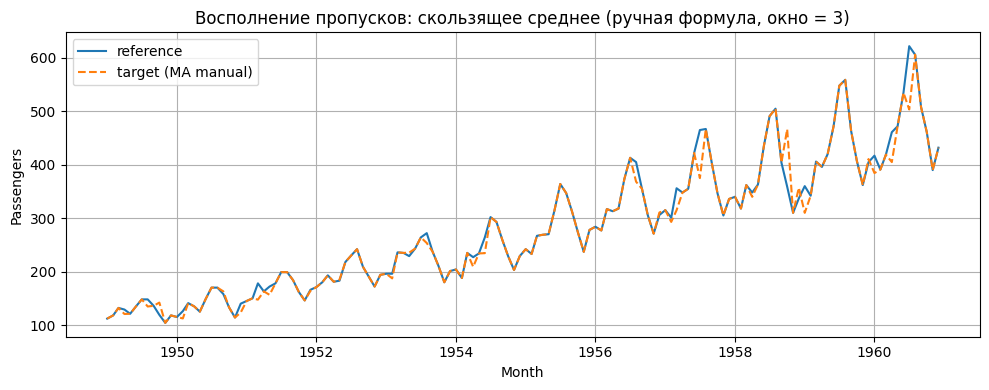

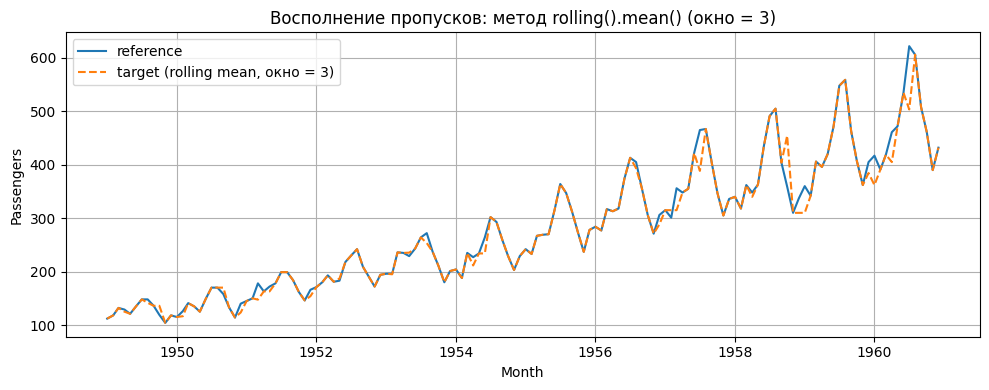

In [5]:
# --- Восполнение пропусков методом скользящего среднего (окно = 3) ---

# Среднее по трём предыдущим значениям — ручная реализация через shift и rolling
ma_manual = target.shift(1).rolling(window=3, min_periods=1).mean()
filled_ma_manual = target.copy().fillna(ma_manual)

# Альтернатива: использование встроенного метода rolling().mean()
ma_builtin = target.rolling(window=3, min_periods=1).mean()
filled_ma_builtin = target.copy().fillna(ma_builtin)

# Добавляем полученные ряды в DataFrame
df['filled_ma_manual'] = filled_ma_manual
df['filled_ma_builtin'] = filled_ma_builtin

# --- Визуализация результатов ---
plt.figure(figsize=(10, 4))
plt.plot(df['Month'], df['reference'], label='reference')
plt.plot(df['Month'], df['filled_ma_manual'], '--', label='target (MA manual)')
plt.title('Восполнение пропусков: скользящее среднее (ручная формула, окно = 3)')
plt.xlabel('Month')
plt.ylabel('Passengers')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(df['Month'], df['reference'], label='reference')
plt.plot(df['Month'], df['filled_ma_builtin'], '--', label='target (rolling mean, окно = 3)')
plt.title('Восполнение пропусков: метод rolling().mean() (окно = 3)')
plt.xlabel('Month')
plt.ylabel('Passengers')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



## 4. Линейная интерполяция

1) График 1: 4.1 Формулой

Если известны две соседние точки с координатами $(x_0, y_0)$ и $(x_1, y_1)$,  
то значение в промежуточной точке $x$ вычисляется как:

$$
y = y_0 + (y_1 - y_0) \cdot \frac{x - x_0}{x_1 - x_0}
$$

Для временной оси `Month` (datetime) долю
$\frac{x - x_0}{x_1 - x_0}$ считаем как долю прошедшего времени между отметками.


2) График 2: 4.2 Через `pandas.Series.interpolate`

Используем метод `interpolate(method='time')` при индексе-времени.


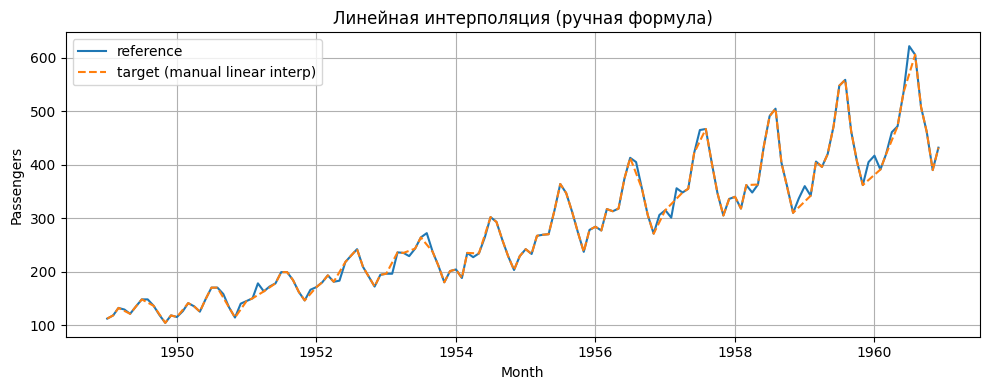

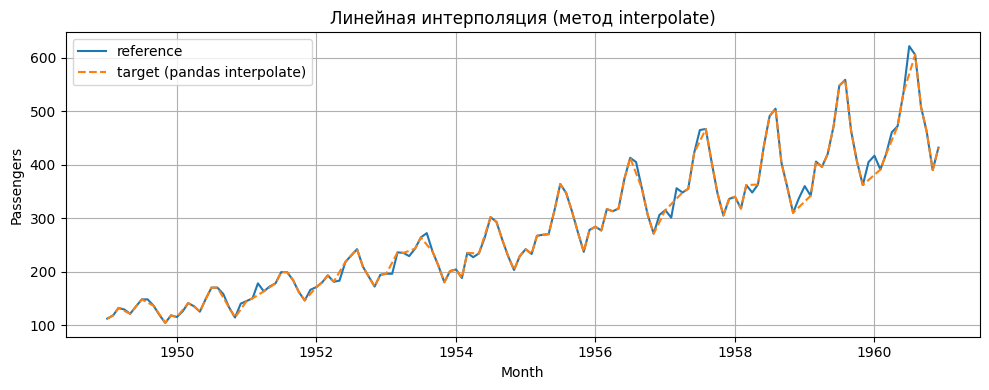

In [6]:
# --- Линейная интерполяция пропусков во временном ряде ---

# Копируем столбец target с индексом Month
target_series = df.set_index('Month')['target'].copy()

# Функция линейного восстановления пропусков по времени
def linear_interp_timeindex(series: pd.Series) -> pd.Series:
    result = series.copy()
    idx = result.index
    mask = result.isna().values
    filled_positions = np.where(~mask)[0]

    # Если нет непустых значений — возвращаем без изменений
    if len(filled_positions) == 0:
        return result

    # Проходим по парам соседних известных точек
    for i in range(len(filled_positions) - 1):
        left, right = filled_positions[i], filled_positions[i + 1]
        if right - left > 1:
            x0, x1 = idx[left], idx[right]
            y0, y1 = result.iloc[left], result.iloc[right]

            # Заполняем пропуски между ними линейно
            for j in range(left + 1, right):
                x = idx[j]
                result.iloc[j] = y0 + (y1 - y0) * ((x - x0) / (x1 - x0))

    return result

# Применяем собственную реализацию и встроенный метод pandas
interp_manual = linear_interp_timeindex(target_series)
interp_builtin = target_series.interpolate(method='time')

# Добавляем результаты в датафрейм
df['interp_manual'] = interp_manual.values
df['interp_builtin'] = interp_builtin.values

# --- Визуализация: ручная формула ---
plt.figure(figsize=(10, 4))
plt.plot(df['Month'], df['reference'], label='reference')
plt.plot(df['Month'], df['interp_manual'], '--', label='target (manual linear interp)')
plt.title('Линейная интерполяция (ручная формула)')
plt.xlabel('Month')
plt.ylabel('Passengers')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Визуализация: pandas interpolate ---
plt.figure(figsize=(10, 4))
plt.plot(df['Month'], df['reference'], label='reference')
plt.plot(df['Month'], df['interp_builtin'], '--', label='target (pandas interpolate)')
plt.title('Линейная интерполяция (метод interpolate)')
plt.xlabel('Month')
plt.ylabel('Passengers')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 5. Простое экспоненциальное сглаживание (SES) для `reference`

Формула рекуррентно:

$$
S_t = \alpha \cdot x_t + (1 - \alpha) \cdot S_{t-1}
$$

где $0 < \alpha \le 1$.

- Чем **выше** \(\alpha\), тем **меньше сглаживание** (быстрее реакция на последние значения).
- Чем **ниже** \(\alpha\), тем **сильнее сглаживание**.

Реализуем два способа: по формуле и через `ewm(alpha=..., adjust=False).mean()`.


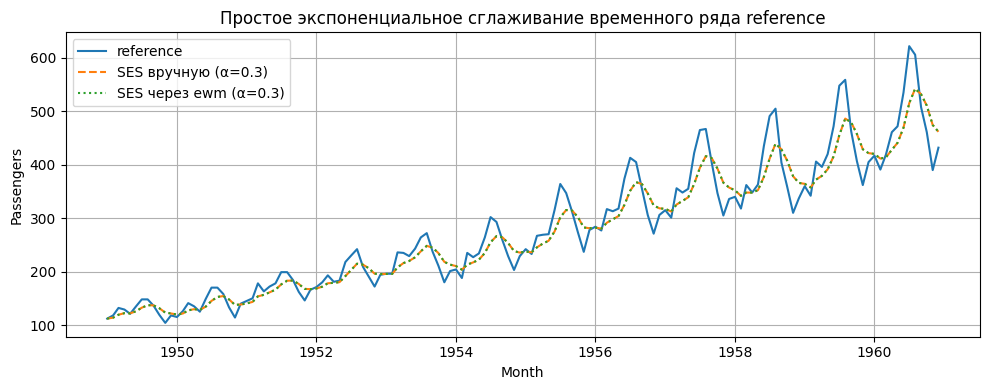

In [7]:
# --- Простое экспоненциальное сглаживание (Simple Exponential Smoothing) ---

alpha = 0.3  # коэффициент сглаживания, 0 < alpha ≤ 1

# Извлекаем значения эталонного ряда
ref_values = df['reference'].astype(float).values

# Реализация SES вручную по формуле:
# S_t = α * X_t + (1 - α) * S_(t-1)
ses_manual = np.empty_like(ref_values, dtype=float)
ses_manual[0] = ref_values[0]  # начальное значение совпадает с первым наблюдением
for t in range(1, len(ref_values)):
    ses_manual[t] = alpha * ref_values[t] + (1 - alpha) * ses_manual[t - 1]

# Добавляем полученный результат в датафрейм
df['ses_manual'] = ses_manual

# Встроенная альтернатива с использованием pandas ewm()
df['ses_builtin'] = df['reference'].ewm(alpha=alpha, adjust=False).mean()

# --- Визуализация результатов ---
plt.figure(figsize=(10, 4))
plt.plot(df['Month'], df['reference'], label='reference')
plt.plot(df['Month'], df['ses_manual'], '--', label=f'SES вручную (α={alpha})')
plt.plot(df['Month'], df['ses_builtin'], ':', label=f'SES через ewm (α={alpha})')
plt.title('Простое экспоненциальное сглаживание временного ряда reference')
plt.xlabel('Month')
plt.ylabel('Passengers')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 6. Итоговые сравнения для восполнений
На следующих графиках — сравнение `reference` с каждым отдельным методом заполнения `target`.


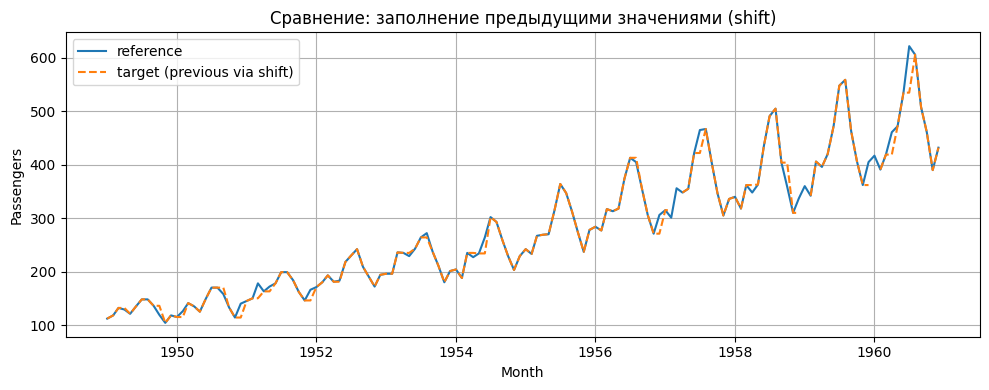

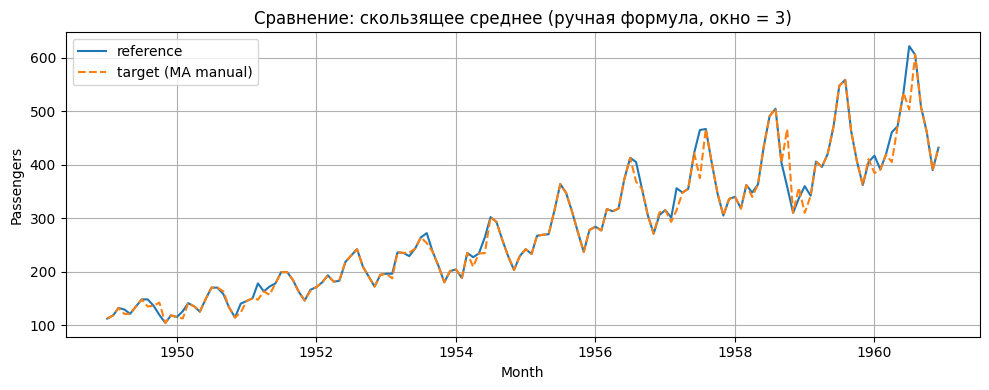

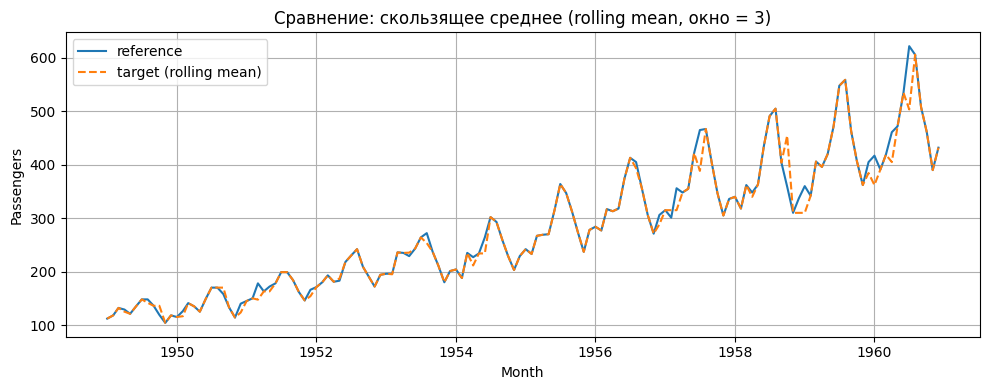

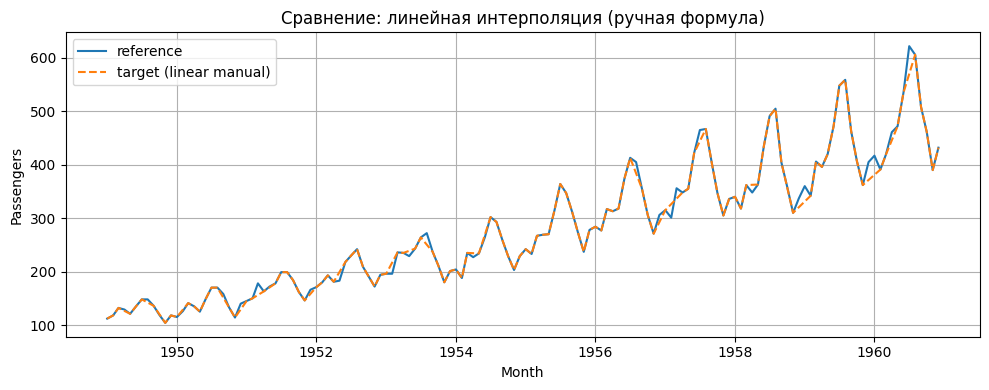

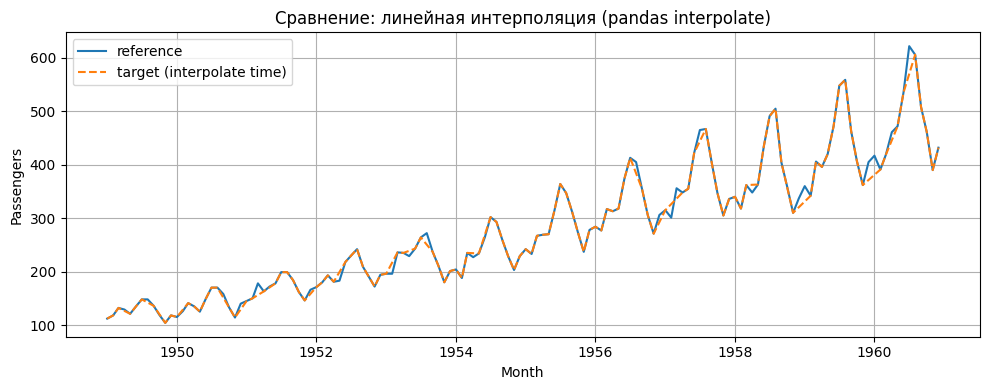

In [9]:
# --- Универсальная функция для построения сравнительных графиков ---

def plot_comparison(x, reference, restored, title, restored_label):
    plt.figure(figsize=(10, 4))
    plt.plot(x, reference, label='reference')
    plt.plot(x, restored, '--', label=restored_label)
    plt.title(title)
    plt.xlabel('Month')
    plt.ylabel('Passengers')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Сравнение результатов различных методов восстановления ---
plot_comparison(df['Month'], df['reference'], df['filled_prev_shift'],
                'Сравнение: заполнение предыдущими значениями (shift)',
                'target (previous via shift)')

plot_comparison(df['Month'], df['reference'], df['filled_ma_manual'],
                'Сравнение: скользящее среднее (ручная формула, окно = 3)',
                'target (MA manual)')

plot_comparison(df['Month'], df['reference'], df['filled_ma_builtin'],
                'Сравнение: скользящее среднее (rolling mean, окно = 3)',
                'target (rolling mean)')

plot_comparison(df['Month'], df['reference'], df['interp_manual'],
                'Сравнение: линейная интерполяция (ручная формула)',
                'target (linear manual)')

plot_comparison(df['Month'], df['reference'], df['interp_builtin'],
                'Сравнение: линейная интерполяция (pandas interpolate)',
                'target (interpolate time)')


### Пошаговое сравнение графиков

1. **Предыдущие значения (shift):**  
   Хорошо передаёт общий тренд, однако на длинных участках с пропусками появляется эффект «ступеней» — значения просто повторяются.  
   На графике видно небольшое отставание восстановленного ряда от исходного.

2. **Скользящее среднее (формула, окно = 3):**  
   Сглаживает флуктуации, но вместе с шумом убирает и острые пики.  
   В результате ряд становится более плавным, хотя теряет детали в экстремальных точках.

3. **Rolling mean (окно = 3):**  
   Поведение очень близко к предыдущему способу — пики чуть приглажены, а переходы между точками становятся мягче.  
   Незначительные расхождения с `reference` заметны при резких изменениях тренда.

4. **Линейная интерполяция (формула):**  
   Точно восстанавливает промежуточные значения между соседними точками.  
   Линия `target` почти полностью совпадает с эталоном — визуально различий почти нет.

5. **Pandas interpolate (time):**  
   Даёт тот же результат, что и ручная линейная интерполяция.  
   На графике линии практически сливаются, подтверждая корректность метода.

# Заключение и интерпретация

Анализ пяти методов показал, что **линейная интерполяция** (как ручная, так и встроенная в pandas) даёт наилучшее совпадение с эталонным рядом `reference`.  
Она восстанавливает пропуски, исходя из прямой зависимости между соседними точками, не искажая форму исходного сигнала и не внося задержек.

### Краткий итог лабораторной работы

* Реализованы все основные подходы к заполнению пропусков:
  - предыдущими значениями (`shift`);
  - скользящим средним (через формулу и `rolling`);
  - линейной интерполяцией (через формулу и `pandas.interpolate`);
* Для каждого метода построены сравнительные графики с эталоном `reference`;
* Дополнительно выполнено **простое экспоненциальное сглаживание** временного ряда `reference` двумя способами — вручную и с помощью `ewm()`.

**Вывод:** для данного временного ряда наилучший результат показала **линейная интерполяция**, так как она максимально точно восстанавливает пропущенные значения без потери динамики и формы исходных данных.